In [1]:
import os
import time

from torchvision.transforms import v2
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from PIL import Image
import tqdm.notebook as tqdm
from IPython import display
import gc 

%load_ext autoreload

from data_loaders import *
%autoreload 2
from training_utils import *
%autoreload 2
from cnn_model import *
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

<Figure size 500x500 with 0 Axes>

In [5]:
# Creating the datasets

transform = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.Normalize(mean=[0], std=[67]),
    # v2.Normalize(mean=[0, 150], std=[100, 100]),
    v2.ToDtype(torch.float, scale=True),
    # v2.ColorJitter(0.5, None, None, None),
    # v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.2, 0.5))
])

target_transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=[0], std=[67]),
    # v2.Normalize(mean=[0, 150], std=[100, 100]),
    v2.ToDtype(torch.float, scale=True),
])


train_labeled_data = CloudDetectionTrain(
    transform=transform
)

test_labeled_data = CloudDetectionTrain(
    target_transform=target_transform
)

In [10]:
def data_split(test_prop, batch_id, boundary_prop, test_module_ids, fold_idx, nfolds):
    assert 0 <= test_prop <= 1, 0 <= val_prop <= 1
    assert 0 <= fold_idx < nfolds, f'fold_idx was set to {fold_idx} but must be in the range [0, {nfolds - 1} = (nfolds - 1)]'
    batch_data = dsl[dsl['batch_id_x'] == batch_id]
    val_prop = 1 / nfolds
    
    if test_module_ids is not None:
        test_data = batch_data[batch_data['module_id'].isin(test_module_ids)].sort_values(by = 'frame_unix_t')
        train_data = batch_data[~batch_data['module_id'].isin(test_module_ids)].sort_values(by = 'frame_unix_t')
        assert len(test_data) > 0 and len(train_data) > 0, 'At least one module_id in test_modules={test_module_ids} is invalid.'        
        test_idx = test_data.index.values

        ntrain = len(train_data)
        nval = int(ntrain / nfolds)
        
        # nbdd = int((ntrain - nval) * boundary_prop / 2)
        left_val_idx = int(nval * fold_idx)
        right_val_idx = int(nval * (fold_idx + 1))
        
        val_idx = train_data[left_val_idx: right_val_idx].index.values
        
        train_idx = np.append(
            train_data[:left_val_idx].index.values,
            train_data[right_val_idx:].index.values
        )
    else:
        batch_data = batch_data.sort_values(by = 'frame_unix_t')
        test_split = int(len(batch_data) * test_prop)
        ntrain = len(batch_data) - test_split
        val_split = int(ntrain * val_prop)
        boundary_cnt = int((len(batch_data) - val_split) * boundary_prop)
        
        test_idx = batch_data[:test_split].index.values
        val_idx = batch_data[test_split: test_split + val_split].index.values
        train_idx = batch_data[test_split + val_split + boundary_cnt:].index.values
    assert len(set(val_idx).intersection(set(train_idx))) == 0, 'Must have non-empty intersection between val_idx and train_idx'
    assert len(set(train_idx).intersection(set(test_idx))) == 0, 'Must have non-empty intersection between train_idx and train_idx'
    assert len(set(val_idx).intersection(set(test_idx))) == 0, 'Must have non-empty intersection between val_idx and train_idx'

    return test_idx, val_idx, train_idx

def get_windowed_test_val_train_indices(test_prop, boundary_prop=0.2, test_module_ids=None, fold_idx=0, nfolds=5):
    test_indices = np.array([], dtype=np.int64)
    val_indices = np.array([], dtype=np.int64)
    train_indices = np.array([], dtype=np.int64)

    for batch_id in dsl['batch_id_x'].unique():
        test_idx, val_idx, train_idx = data_split(
            test_prop, batch_id, boundary_prop, test_module_ids, fold_idx, nfolds
        )
        test_indices = np.concatenate((test_indices, test_idx))
        val_indices = np.concatenate((val_indices, val_idx))
        train_indices = np.concatenate((train_indices, train_idx))
    return test_indices, val_indices, train_indices


def get_shuffled_test_val_train_indices(test_prop, val_prop):
    dataset_size = len(dsl)
    dataset_indices = np.arange(dataset_size)
    
    np.random.shuffle(dataset_indices)
    
    # Test / Train split
    test_split_index = int(np.floor(test_prop * dataset_size))
    trainset_indices, test_idx = dataset_indices[test_split_index:], dataset_indices[:test_split_index]
    
    # Train / Val split
    trainset_size = len(trainset_indices)
    val_split_index = int(np.floor(val_prop * trainset_size))
    train_idx, val_idx = trainset_indices[val_split_index:], trainset_indices[:val_split_index]
    return test_idx, val_idx, train_idx

def preview_frames(data_loader):
    try:
        for X, Y in data_loader:
            for img in X:
                plt.imshow(img.reshape((32,32)), vmin=-2, vmax=2, cmap='icefire')
                plt.show()
                plt.close()
                time.sleep(.01)
                display.clear_output(wait=True)
    except KeyboardInterrupt:
        plt.close()
    finally:
        plt.close()
        gc.collect()

In [15]:
test_prop = 0.3
nfolds = 6
boundary_prop = 0.1 # Proportion of data to discard between the validation and train_proportions (time)

batch_size = 64

1/nfolds

0.16666666666666666

In [18]:
dsl = train_labeled_data.dsl_df
dataset_size = len(dsl)

test_idx, val_idx, train_idx = get_windowed_test_val_train_indices(
    test_prop, boundary_prop, test_module_ids=[3], fold_idx=4, nfolds=nfolds
)
# test_idx, val_idx, train_idx = get_shuffled_test_val_train_indices(test_prop, val_prop)
# print(test_idx, val_idx, train_idx)

test_loader = torch.utils.data.DataLoader(
  dataset=test_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(test_idx)
)

train_loader = torch.utils.data.DataLoader(
  dataset=train_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(train_idx)
)

val_loader = torch.utils.data.DataLoader(
  dataset=test_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.sampler.SubsetRandomSampler(val_idx)
)


# Get dataset stats

print(f'test_prop (of dataset) = {100 * len(test_idx) / dataset_size:.2f}%\n'
      f'train_prop (of trainset)= {100 * len(train_idx) / (len(val_idx) + len(train_idx)):.2f}%\n'
      f'val_prop (of trainset) = {100 * len(val_idx) / (len(val_idx) + len(train_idx)):.2f}%'
)
# feature_uid = train_labeled_data.dsl_df.loc[:, 'feature_uid'].iloc[0]
# train_labeled_data[0][0]
def print_class_dist(data, idx, name):
    filtered_data = data.iloc[idx]
    num_clear = len(filtered_data.loc[filtered_data['label'] == 'clear_night_sky'])
    num_cloudy = len(filtered_data.loc[filtered_data['label'] == 'not_clear_cloudy'])

    unique_module_ids = list(np.sort(filtered_data["module_id"].unique()))
    
    print(f'Percent cloudy (in {name}) = {100 *num_cloudy / len(filtered_data):.3f}% ({num_cloudy} / {len(filtered_data)}); '
          f'Unique module_ids: {unique_module_ids}')

print_class_dist(dsl, test_idx, 'test')
print_class_dist(dsl, val_idx, 'val')
print_class_dist(dsl, train_idx, 'train')
print_class_dist(dsl, dsl.index, 'overall')
print(len(val_idx) / (len(val_idx) + len(train_idx)))
print(min(val_idx))

test_prop (of dataset) = 33.34%
train_prop (of trainset)= 83.38%
val_prop (of trainset) = 16.62%
Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
Percent cloudy (in val) = 53.333% (520 / 975); Unique module_ids: [1, 254]
Percent cloudy (in train) = 55.706% (2724 / 4890); Unique module_ids: [1, 254]
Percent cloudy (in overall) = 55.052% (4844 / 8799); Unique module_ids: [1, 3, 254]
0.16624040920716113
88


In [63]:
def do_cross_validation(test_prop, nfolds):
    
    test_loader = None
    validation_accuracies = []
    trainers = []
    for fold_idx in range(nfolds):
        # Get data splits
        test_idx, val_idx, train_idx = get_windowed_test_val_train_indices(
            test_prop, boundary_prop, test_module_ids=[3], fold_idx=fold_idx, nfolds=nfolds
        )

        # Make dataloaders
        train_loader = torch.utils.data.DataLoader(
          dataset=train_labeled_data,
          batch_size=batch_size,
          sampler=torch.utils.data.SubsetRandomSampler(train_idx)
        )
        
        val_loader = torch.utils.data.DataLoader(
          dataset=test_labeled_data,
          batch_size=batch_size,
          sampler=torch.utils.data.sampler.SubsetRandomSampler(val_idx)
        )

        if test_loader is None:
            test_loader = torch.utils.data.DataLoader(
              dataset=test_labeled_data,
              batch_size=batch_size,
              sampler=torch.utils.data.SubsetRandomSampler(test_idx)
            )
            # Print stats
            print_class_dist(dsl, test_idx, 'test')
            print_class_dist(dsl, val_idx, 'val')
            print_class_dist(dsl, train_idx, 'train')
            print_class_dist(dsl, dsl.index, 'overall')

        

        # Create model
        model = CloudDetection()
        
        # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-6)#, momentum=momentum)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        loss_fn = nn.CrossEntropyLoss()
        
        trainer = Trainer(
            model, optimizer, loss_fn, train_loader, val_loader,
            epochs=epochs, gamma=gamma, do_summary=False,
            # img_type=img_type
        )
        print(f'Doing Fold {fold_idx} of {nfolds}')
        trainer.train(make_train_logs=False, write_plots=False)
        
        average_validation_accuracies_in_last_5_epochs = trainer.training_log['val']['acc'][-5:]
        validation_accuracies.append(average_validation_accuracies_in_last_5_epochs)

        # Cleanup
        trainer.model.to('cpu')
        trainers.append(trainer)
    print(f'Average validation accuracy: {np.mean(validation_accuracies)}')
    return validation_accuracies, trainers

In [ ]:
learning_rate = 0.001
weight_decay = 1e-5
epochs = 20
gamma = 0.9
validation_accuracies, trainers = do_cross_validation(0.3, 5)

Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
Percent cloudy (in val) = 53.550% (626 / 1169); Unique module_ids: [1, 254]
Percent cloudy (in train) = 55.750% (2618 / 4696); Unique module_ids: [1, 254]
Percent cloudy (in overall) = 55.052% (4844 / 8799); Unique module_ids: [1, 3, 254]
Doing Fold 0 of 5


Epoch 1


  0%|          | 0/74 [00:00<?, ?batches/s]

In [40]:
# Training config
del model
del optimizer
del trainer

learning_rate = 0.001
weight_decay = 1e-5
epochs = 20
gamma = 0.9
# momentum=0.9

model = CloudDetection()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-6)#, momentum=momentum)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()


trainer = Trainer(
    model, optimizer, loss_fn, train_loader, val_loader,
    epochs=epochs, gamma=gamma, do_summary=True,
    # img_type=img_type
);
gc.collect();


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 24, 10, 10]          --
|    └─Conv2d: 2-1                       [-1, 24, 32, 32]          240
|    └─ReLU: 2-2                         [-1, 24, 32, 32]          --
|    └─BatchNorm2d: 2-3                  [-1, 24, 32, 32]          48
|    └─Dropout2d: 2-4                    [-1, 24, 32, 32]          --
|    └─Conv2d: 2-5                       [-1, 24, 32, 32]          5,208
|    └─ReLU: 2-6                         [-1, 24, 32, 32]          --
|    └─BatchNorm2d: 2-7                  [-1, 24, 32, 32]          48
|    └─Dropout2d: 2-8                    [-1, 24, 32, 32]          --
|    └─Conv2d: 2-9                       [-1, 24, 32, 32]          5,208
|    └─ReLU: 2-10                        [-1, 24, 32, 32]          --
|    └─BatchNorm2d: 2-11                 [-1, 24, 32, 32]          48
|    └─MaxPool2d: 2-12                   [-1, 24, 10, 10]          --
|    └─D

In [37]:
trainer.train(make_train_logs=False)



Epoch 1


  0%|          | 0/77 [00:00<?, ?batches/s]

Keyboard Interrupt: Stopping training


  0%|          | 0/46 [00:00<?, ?batches/s]

<Figure size 500x500 with 0 Axes>

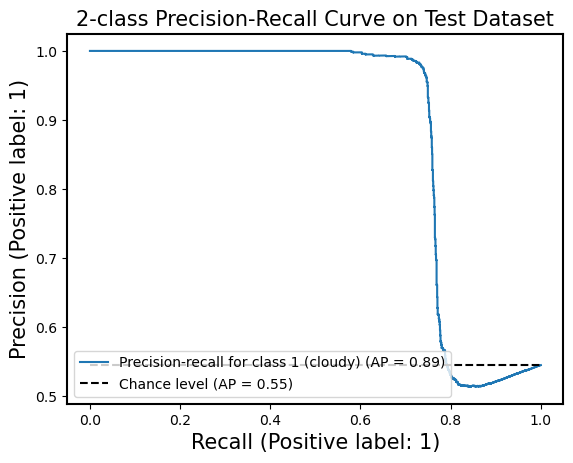

Test: 	loss = 0.4704,  acc = 2639/2934 (89.95%)


In [26]:
tester = Tester(model, loss_fn, test_loader)
tester.eval()

  0%|          | 0/46 [00:00<?, ?batches/s]

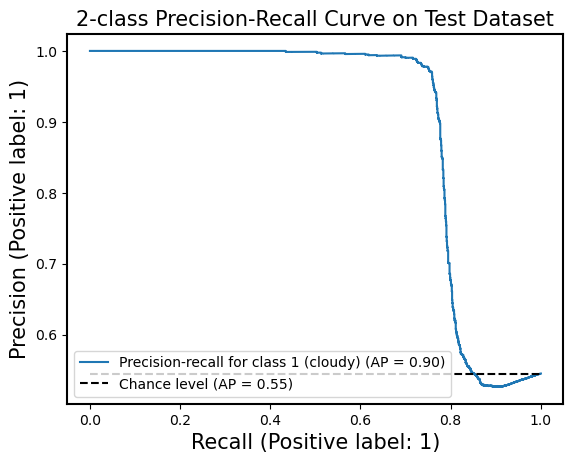

Test: 	loss = 0.4796,  acc = 2637/2934 (89.88%)


In [90]:
model.load_state_dict(torch.load('../model_training/best_cloud_detection_model.pth'))
tester = Tester(model, loss_fn, test_loader)
tester.eval()